### Import dependencies

In [1]:
import numpy as np
import pandas as pd
from azureml.core import Workspace
import os
import io
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
load_dotenv()


True

### Load Train and Test Data

In [2]:
def save_dataframe_to_blob(dataframe, container_name, blob_name):
    # Get connection string from environment variables
    connection_string = os.getenv('connection_string')
    if not connection_string:
        raise ValueError("connection_string is not set in the .env file")
    # Initialize BlobServiceClient
    try:
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        print("Successfully connected to Azure Blob Storage.")
    except ValueError as e:
        print(f"Error initializing BlobServiceClient: {e}")
        raise
    # Ensure the container exists
    try:
        container_client = blob_service_client.get_container_client(container_name)
        if not container_client.exists():
            container_client.create_container()
            print(f"Created container: {container_name}")
        else:
            print(f"Container {container_name} already exists.")
    except Exception as e:
        print(f"Error creating/getting container client: {e}")
        raise
    # Convert dataframe to CSV string
    csv_data = dataframe.to_csv(index=False)
    # Upload CSV string to blob storage
    try:
        blob_client = container_client.get_blob_client(blob_name)
        blob_client.upload_blob(csv_data, overwrite=True)
        print(f"Uploaded {blob_name} to blob storage in container {container_name}")
    except Exception as e:
        print(f"Error uploading blob: {e}")
        raise


def load_dataframe_from_blob(container_name, blob_name):
    """
    Loads a CSV file from Azure Blob Storage into a Pandas DataFrame.
    Args:
        container_name (str): The name of the Azure Blob Storage container.
        blob_name (str): The name of the blob to download.
    Returns:
        pandas.DataFrame: The loaded DataFrame.
    """
    # Get connection string from environment variables
    connection_string = os.getenv('connection_string')
    if not connection_string:
        raise ValueError("connection_string is not set in the .env file")
    # Initialize BlobServiceClient
    try:
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        print("Successfully connected to Azure Blob Storage.")
    except ValueError as e:
        print(f"Error initializing BlobServiceClient: {e}")
        raise
    # Get blob client
    try:
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    except Exception as e:
        print(f"Error getting blob client: {e}")
        raise
    # Download blob content to a byte stream
    download_stream = blob_client.download_blob()
    blob_data = download_stream.readall()
    # Create a Pandas DataFrame from the byte stream
    df = pd.read_csv(io.BytesIO(blob_data))
    return df

In [3]:
connection_string = os.getenv('connection_string')
container_name = os.getenv('container_name')
blob_name = os.getenv('train_blob_name')

In [4]:
df_train = load_dataframe_from_blob(container_name, blob_name)
print(df_train.shape)
print('')
df_train.head()

Successfully connected to Azure Blob Storage.
(455401, 25)



UserID  basket_icon_click  basket_add_list  \
0  a720-6b732349-a720-4862-bd21-644732                  0                0   
1  a0c0-6b73247c-a0c0-4bd9-8baa-797356                  0                0   
2  86a8-6b735c67-86a8-407b-ba24-333055                  0                0   
3  6a3d-6b736346-6a3d-4085-934b-396834                  0                0   
4  b74a-6b737717-b74a-45c3-8c6a-421140                  0                1   

   basket_add_detail  sort_by  image_picker  account_page_click  \
0                  0        0             0                   0   
1                  0        0             0                   0   
2                  0        0             0                   0   
3                  0        0             0                   0   
4                  0        1             0                   0   

   promo_banner_click  detail_wishlist_add  list_size_dropdown  ...  \
0                   0                    0                   0  ...   
1                   0                    0                   0  ...   
2                   0                    0                   0  ...   
3                   0                    0                   0  ...   
4                   0                    0                   1  ...   

   saw_sizecharts  saw_delivery  saw_account_upgrade  saw_homepage  \
0               0             0                    0             0   
1               0             0                    0             0   
2               0             0                    0             0   
3               0             0                    0             0   
4               0             0                    0             1   

   device_mobile  device_computer  device_tablet  returning_user  loc_uk  \
0              1                0              0               0       1   
1              1                0              0               0       1   
2              1                0              0               1       1   
3              1                0              0               1       1   
4              0                0              1               0       1   

   ordered  
0        0  
1        0  
2        0  
3        0  
4        1  

[5 rows x 25 columns]

### Check for Basic data checks

In [5]:
#Variable info
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455401 entries, 0 to 455400
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   455401 non-null  object
 1   basket_icon_click        455401 non-null  int64 
 2   basket_add_list          455401 non-null  int64 
 3   basket_add_detail        455401 non-null  int64 
 4   sort_by                  455401 non-null  int64 
 5   image_picker             455401 non-null  int64 
 6   account_page_click       455401 non-null  int64 
 7   promo_banner_click       455401 non-null  int64 
 8   detail_wishlist_add      455401 non-null  int64 
 9   list_size_dropdown       455401 non-null  int64 
 10  closed_minibasket_click  455401 non-null  int64 
 11  checked_delivery_detail  455401 non-null  int64 
 12  checked_returns_detail   455401 non-null  int64 
 13  sign_in                  455401 non-null  int64 
 14  saw_checkout        

### EDA

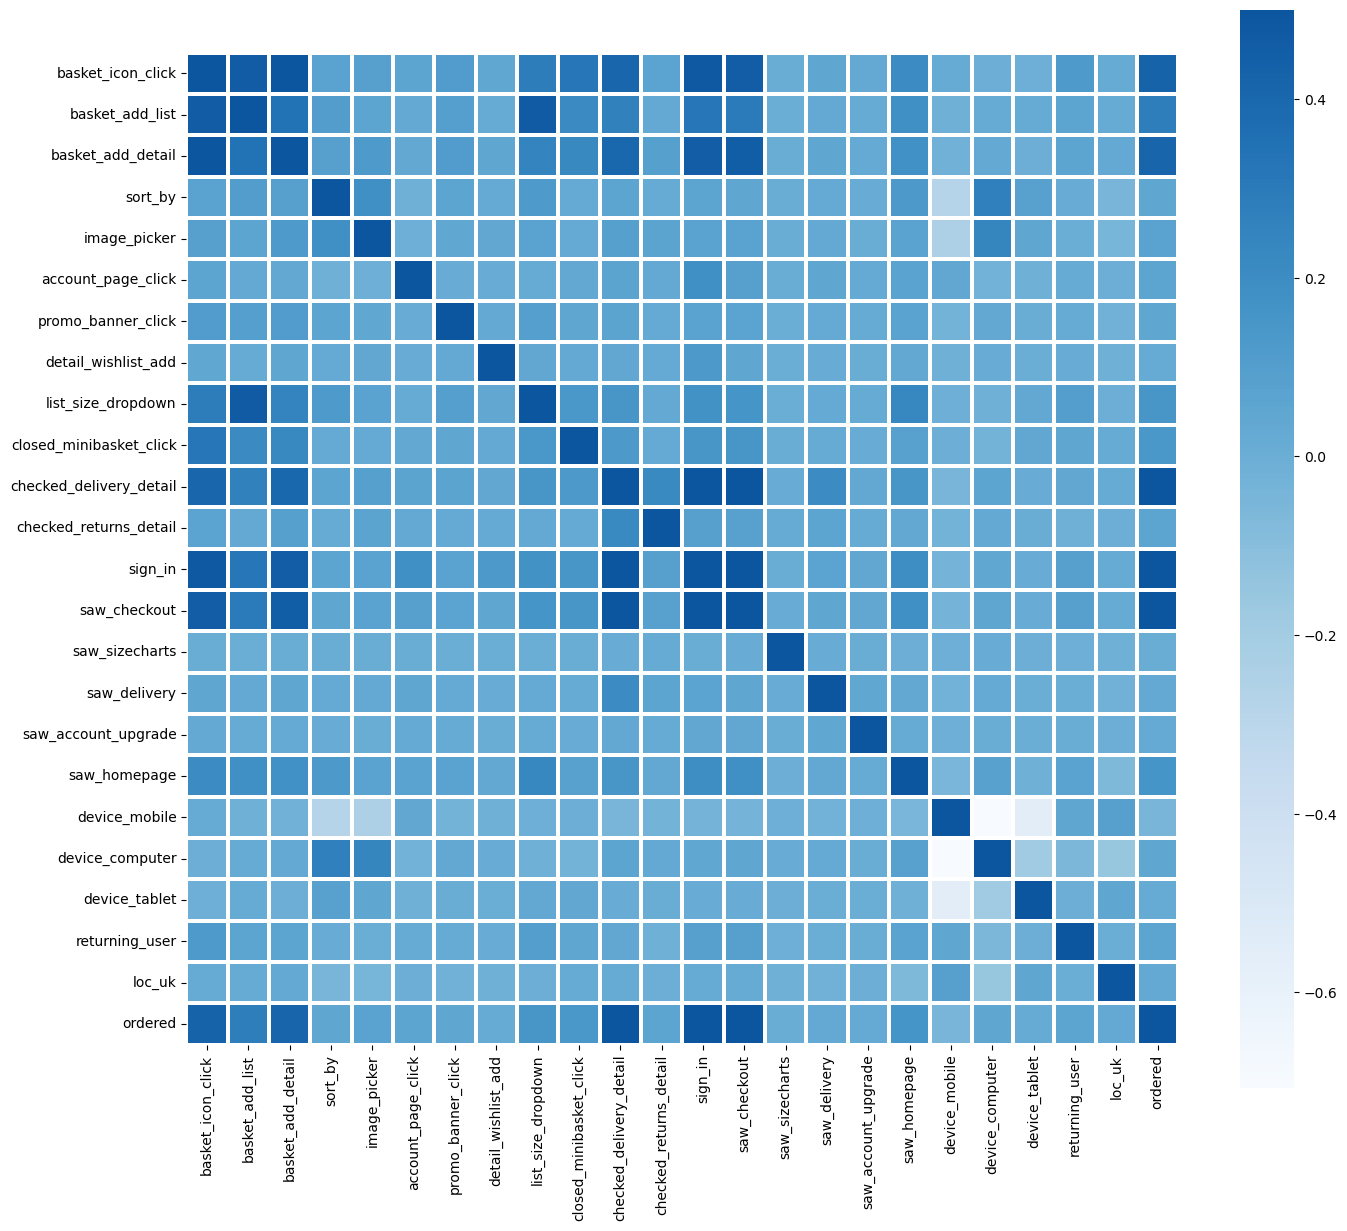

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_train.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues')
plt.savefig("heatmap.png")
plt.show()

In [7]:
df_train.corr()['ordered']

basket_icon_click          0.428334
basket_add_list            0.287666
basket_add_detail          0.414420
sort_by                    0.054636
image_picker               0.071492
account_page_click         0.057279
promo_banner_click         0.056533
detail_wishlist_add        0.023516
list_size_dropdown         0.154867
closed_minibasket_click    0.140011
checked_delivery_detail    0.798720
checked_returns_detail     0.059484
sign_in                    0.665556
saw_checkout               0.708986
saw_sizecharts             0.007548
saw_delivery               0.031461
saw_account_upgrade        0.025857
saw_homepage               0.157778
device_mobile             -0.042907
device_computer            0.049208
device_tablet              0.016939
returning_user             0.060295
loc_uk                     0.031643
ordered                    1.000000
Name: ordered, dtype: float64

In [8]:
# Drop columns with High Corr to avoid Multicollinearity
df_train = df_train.drop(['checked_delivery_detail'], axis=1)

In [9]:
df_train.columns

Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_returns_detail', 'sign_in', 'saw_checkout', 'saw_sizecharts',
       'saw_delivery', 'saw_account_upgrade', 'saw_homepage', 'device_mobile',
       'device_computer', 'device_tablet', 'returning_user', 'loc_uk',
       'ordered'],
      dtype='object')

### Feature Selection
- Variance Threshold check
- Select k best for top n features

In [10]:
id_target_col_list = ['ordered', 'UserID']
col_for_feature_selection = df_train.columns.difference(id_target_col_list)
print(len(col_for_feature_selection))

22


In [11]:
from sklearn.feature_selection import VarianceThreshold

var_thr = VarianceThreshold(threshold = 0.005) #Removing both constant and quasi-constant
var_thr.fit(df_train[col_for_feature_selection])

# Get the support mask
support = var_thr.get_support()

print("Support:", support)

Support: [False  True  True  True  True  True False  True  True  True  True  True
  True  True  True False  True  True  True False  True  True]


In [12]:
# List of columns to be retained
print(len(df_train.columns))
print('')
retained_columns = df_train[col_for_feature_selection].columns[support]

# List of columns to be removed
remove_col_list = [col for col in col_for_feature_selection if col not in retained_columns]
print("Columns to be removed:", remove_col_list)

24

Columns to be removed: ['account_page_click', 'detail_wishlist_add', 'saw_account_upgrade', 'saw_sizecharts']


In [13]:
print(df_train.shape)
print('')
df_train = df_train.drop(remove_col_list, axis=1, errors='ignore')
print(df_train.shape)

(455401, 24)

(455401, 20)


In [14]:
df_train.columns

Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'promo_banner_click', 'list_size_dropdown',
       'closed_minibasket_click', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_delivery', 'saw_homepage', 'device_mobile',
       'device_computer', 'device_tablet', 'returning_user', 'loc_uk',
       'ordered'],
      dtype='object')

### Feature Selection Using Select K Best

In [15]:
#Select top n Features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def select_kbest_features(df, target_col,n):
  """
  Selects the top n features from the DataFrame using the SelectKBest algorithm.

  Args:
    df: The DataFrame to select features from.
    n: The number of features to select.

  Returns:
    A list of the top n features.
  """


  selector = SelectKBest(k=n)
  selected_features = selector.fit_transform(df, target_col)
  
  mask = selector.get_support()
  top_n_features = df.columns[mask]

  return top_n_features

In [16]:
id_col_list = ['UserID']
target_col = df_train['ordered']
top_n_col_list = select_kbest_features(df_train.drop(id_col_list,axis=1),target_col, 10)
print(len(top_n_col_list))
top_n_col_list

10


/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'image_picker', 'list_size_dropdown', 'closed_minibasket_click',
       'sign_in', 'saw_checkout', 'saw_homepage', 'ordered'],
      dtype='object')

In [17]:
#Convert to list
top_n_col_list = top_n_col_list.tolist()

type(top_n_col_list)

list

In [18]:
cols_for_model_df_list = id_col_list + top_n_col_list
print(len(cols_for_model_df_list))
print('')

11



In [19]:
df_train_feature_eng_output = df_train[cols_for_model_df_list]
df_train_feature_eng_output.head()

UserID  basket_icon_click  basket_add_list  \
0  a720-6b732349-a720-4862-bd21-644732                  0                0   
1  a0c0-6b73247c-a0c0-4bd9-8baa-797356                  0                0   
2  86a8-6b735c67-86a8-407b-ba24-333055                  0                0   
3  6a3d-6b736346-6a3d-4085-934b-396834                  0                0   
4  b74a-6b737717-b74a-45c3-8c6a-421140                  0                1   

   basket_add_detail  image_picker  list_size_dropdown  \
0                  0             0                   0   
1                  0             0                   0   
2                  0             0                   0   
3                  0             0                   0   
4                  0             0                   1   

   closed_minibasket_click  sign_in  saw_checkout  saw_homepage  ordered  
0                        0        0             0             0        0  
1                        0        0             0             0        0  
2                        0        0             0             0        0  
3                        0        0             0             0        0  
4                        0        1             1             1        1

In [20]:
df_train_feature_eng_output['ordered'].value_counts()
print('')
print(df_train_feature_eng_output['ordered'].value_counts(normalize= True))


0    0.958074
1    0.041926
Name: ordered, dtype: float64


#### Save the output to Blob storage

In [21]:
save_dataframe_to_blob(df_train_feature_eng_output,'processed-files','processed_train_df.csv')

Successfully connected to Azure Blob Storage.
Container processed-files already exists.
Uploaded processed_train_df.csv to blob storage in container processed-files


### Processing the Test Data

In [22]:
blob_name = os.getenv('test_blob_name')
df_test = load_dataframe_from_blob(container_name, blob_name)
print(df_test.shape)
print('')
df_test.head()

Successfully connected to Azure Blob Storage.
(151655, 25)



UserID  basket_icon_click  basket_add_list  \
0  9d24-25k4-47889d24-25k4-494b-398124                  0                0   
1  7732-1k58-47887732-1k58-4475-679678                  0                0   
2  94k2-632j-471394k2-632j-4b4j-228160                  0                0   
3  jdd8-419d-4714jdd8-419d-4198-674376                  0                0   
4  7473-7595-47147473-7595-4757-227547                  0                0   

   basket_add_detail  sort_by  image_picker  account_page_click  \
0                  0        0             0                   0   
1                  0        0             0                   0   
2                  0        0             0                   0   
3                  1        0             0                   0   
4                  0        0             0                   0   

   promo_banner_click  detail_wishlist_add  list_size_dropdown  ...  \
0                   0                    0                   0  ...   
1                   0                    0                   0  ...   
2                   0                    0                   0  ...   
3                   0                    0                   0  ...   
4                   0                    0                   0  ...   

   saw_sizecharts  saw_delivery  saw_account_upgrade  saw_homepage  \
0               0             0                    0             0   
1               0             0                    0             0   
2               0             0                    0             0   
3               0             0                    0             0   
4               0             0                    0             0   

   device_mobile  device_computer  device_tablet  returning_user  loc_uk  \
0              1                0              0               0       1   
1              1                0              0               0       1   
2              1                0              0               0       1   
3              1                0              0               0       1   
4              1                0              0               0       1   

   ordered  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 25 columns]

In [23]:
# Drop columns with High Corr to avoid Multicollinearity
df_test = df_test.drop(['checked_delivery_detail'], axis=1)
print(df_test.shape)

(151655, 24)


In [24]:
print(df_test.shape)
print('')
df_test = df_test.drop(remove_col_list, axis=1, errors='ignore')
print(df_test.shape)

(151655, 24)

(151655, 20)


In [25]:
df_test_feature_eng_output = df_test[cols_for_model_df_list]
df_test_feature_eng_output.head()

UserID  basket_icon_click  basket_add_list  \
0  9d24-25k4-47889d24-25k4-494b-398124                  0                0   
1  7732-1k58-47887732-1k58-4475-679678                  0                0   
2  94k2-632j-471394k2-632j-4b4j-228160                  0                0   
3  jdd8-419d-4714jdd8-419d-4198-674376                  0                0   
4  7473-7595-47147473-7595-4757-227547                  0                0   

   basket_add_detail  image_picker  list_size_dropdown  \
0                  0             0                   0   
1                  0             0                   0   
2                  0             0                   0   
3                  1             0                   0   
4                  0             0                   0   

   closed_minibasket_click  sign_in  saw_checkout  saw_homepage  ordered  
0                        0        0             0             0        0  
1                        0        0             0             0        0  
2                        0        0             0             0        0  
3                        0        0             0             0        0  
4                        0        0             0             0        0

In [26]:
print(df_test_feature_eng_output['ordered'].value_counts())
print('')
print(df_test_feature_eng_output['ordered'].value_counts(normalize= True))

0    151655
Name: ordered, dtype: int64

0    1.0
Name: ordered, dtype: float64


#### Save the output to Blob storage

In [27]:
save_dataframe_to_blob(df_test_feature_eng_output,'processed-files','processed_test_df.csv')


Successfully connected to Azure Blob Storage.
Container processed-files already exists.
Uploaded processed_test_df.csv to blob storage in container processed-files
